In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from scipy.signal import wiener
%matplotlib inline

# Load data 

In [49]:
X_train = np.genfromtxt('data/Xtr.csv',delimiter=',')
y_train = np.genfromtxt('data/Ytr.csv',delimiter=',')
X_test = np.genfromtxt('data/Xte.csv',delimiter=',')

In [50]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(5000, 3073)
(5001, 2)
(2000, 3073)


In [51]:
print("Number of classes: ",len(np.unique(y_train[:,1]))-1) # - 1 because first line (header) produces a nan

Number of classes:  10


In [52]:
y_train[1:,1]

array([ 8.,  9.,  3., ...,  1.,  7.,  5.])

In [53]:
counts = np.zeros(10)
for i in range(1,len(y_train)):
    cl = y_train[i,1] 
    counts[cl] += 1

for i in range(len(counts)):
    print("Class ",i, " , n_elements = ",counts[i])

Class  0  , n_elements =  500.0
Class  1  , n_elements =  500.0
Class  2  , n_elements =  500.0
Class  3  , n_elements =  500.0
Class  4  , n_elements =  500.0
Class  5  , n_elements =  500.0
Class  6  , n_elements =  500.0
Class  7  , n_elements =  500.0
Class  8  , n_elements =  500.0
Class  9  , n_elements =  500.0


/Users/camillejandot/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [54]:
if y_train.shape[0]==len(np.unique(y_train[1])):
    print("Ids in y_train are unique")

In [55]:
# Last column is a column of nans, we remove it and thus obtain 3072 columns as precised in the documentation
X_train = X_train[:,:-1]
X_test = X_test[:,:-1]
y_train = y_train[1:,1]

In [56]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(5000, 3072)
(5000,)
(2000, 3072)


# Visualize data

In [57]:
plt.imshow?

In [58]:
# Boundaries for red channel
print(X_train[:,0:1024].min())
print(X_train[:,0:1024].max())
# Boundaries for green channel
print(X_train[:,1024:2048].min())
print(X_train[:,1024:2048].max())
# Boundaries for blue channel
print(X_train[:,2048:].min())
print(X_train[:,2048:].max())

-0.3187875
0.402814
-0.3442333
0.3582715
-0.4618988
0.380387


In [59]:
def show_image(X,id_img,incr_contrast=True):
    image = X[id_img].copy()
    r = image[:1024].reshape(32,32)
    g = image[1024:2048].reshape(32,32)
    b = image[2048:].reshape(32,32)
    
    def increase_contrast_rescale(channel,incr_contrast):
        threshold = 0.5 * np.ones((32,32))
        channel += threshold
        if incr_contrast:
            delta = np.power(channel,2.5)
            channel += delta 
        n_over = 0
        n_under = 0
        for i in range(channel.shape[0]):
            for j in range(channel.shape[1]):
                if channel[i,j]>1.:
                    channel[i,j] = 1.
                    n_over += 1
                elif channel[i,j]<0.:
                    channel[i,j] = 0.
                    n_under += 1
        #print("Contrast over ",n_over)
        #print("Contrast under ",n_under)
        return channel
    
    r = increase_contrast_rescale(r,incr_contrast)
    g = increase_contrast_rescale(g,incr_contrast)
    b = increase_contrast_rescale(b,incr_contrast)
    
    threshold = 0.5 * np.ones((32,32))
    image_3 = np.zeros((32,32,3))
    image_3[:,:,0] = r #+ threshold
    image_3[:,:,1] = g #+ threshold
    image_3[:,:,2] = b #+ threshold
    
    plt.figure()
    plt.imshow(image_3)

In [83]:
def show_channel(img,channel):
    """
    channel 0,1,2,3 for r,g,b,all (resp.)
    -1 : only one channel in output
    """
    image = img.copy()
    if channel==0:
        r = image[:1024].reshape(32,32)
        plt.figure()
        plt.imshow(r, cmap='gray')
        plt.title('red channel')
    elif channel==1:
        g = image[1024:2048].reshape(32,32)
        plt.figure()
        plt.imshow(g, cmap='gray')
        plt.title('green channel')
    elif channel==2:
        b = image[2048:].reshape(32,32)
        plt.figure()
        plt.imshow(b, cmap='gray')
        plt.title('blue channel')
    elif channel == 3:
        r = image[:1024].reshape(32,32)
        plt.figure()
        plt.imshow(r, cmap='gray')
        plt.title('red channel')
        g = image[1024:2048].reshape(32,32)
        plt.figure()
        plt.imshow(g, cmap='gray')
        plt.title('green channel')
        b = image[2048:].reshape(32,32)
        plt.figure()
        plt.imshow(b, cmap='gray')
        plt.title('blue channel')
    else:
        plt.figure()
        plt.imshow(img, cmap='gray')



In [61]:
print(y_train[:50])

[ 8.  9.  3.  1.  4.  5.  9.  0.  3.  3.  5.  3.  7.  6.  7.  5.  8.  8.
  5.  3.  8.  9.  8.  5.  7.  2.  0.  9.  8.  4.  4.  6.  6.  6.  0.  3.
  9.  6.  8.  9.  8.  1.  8.  3.  5.  9.  3.  3.  2.  7.]


Les id sont indexés en python (à partir de 0) alors que dans le fichier de y_train, ils sont indexés à partir de 1 !!

- 0: plane (id 7,26)
- 1: car (id 300)
- 2: bird? (id 25,48, better with 74,94)
- 3: cat (id 2,8,9,11,19,35,43, better with 108)
- 4: ?? an animal? perhaps a deer? (id 4,24 better with 84)
- 5: dog (id 5,10,15,18,23, better with 81,99)
- 6: frog?? (id 13, 31,32,33,35,better with 70,96)
- 7: horse (id 12,14,24)
- 8: boat (id 0)
- 9: truck (id 1,6,36,39,45, better with 67 or 69)

3.0


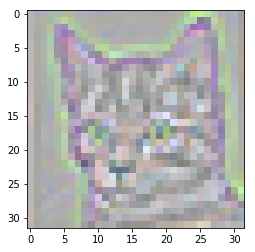

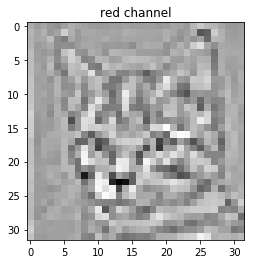

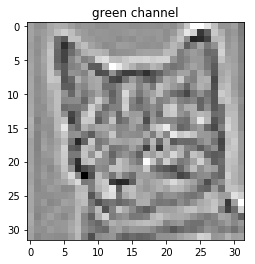

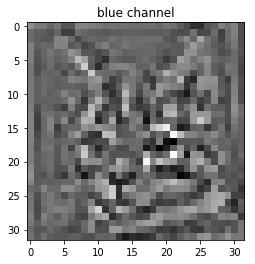

In [62]:
id_img = 108
print(y_train[id_img])
show_image(X_train,id_img,incr_contrast=True)
show_channel(X_train[id_img],3)

### TODO
Pour l'instant on n'y pas grand chose de plusquand on regarde RGB (fonction show_image). Les coefficients ont l'air compris entre -0.5 et 0.5, et il faut qu'ils soient compris entre 0 et 1... Je sais pas trop comment les rescaler... Pour l'instant, j'ai juste ajouté un threshold de 0.5, mais c'est très moche !!! Il faudrait trouver la façon dont ça a été encodé si on veut mieux voir

# Begin to implement One-vs-All (Multiclass)

In [403]:
def distance_to_separator(w_sep,b_sep,point):
    """
    Computes the distance between a point and the separating hyperplane.
    Useful for one vs all to determine the classifier that better classifies a point
    """
    return np.abs(np.dot(w_sep,point)+b_sep)/np.linalg.norm(w_sep)

In [412]:
def one_vs_all_svm(n_class,X_train,y_train):  
    X_train_t = X_train[:4000]
    X_train_v = X_train[4000:]

    positive_for_class = np.zeros((n_class,len(X_train_v)))
    distance_to_sep = np.zeros((n_class,len(X_train_v)))
    
    classes = []
    for cl in range(n_class):
        print('*** Learning SVM classifier for class ',cl)
        
        # Build binary y for classifier for class cl
        y_train_cl = np.zeros(y_train.shape)
        indices = []
        for i in range(len(y_train)):
            
            if y_train[i] == cl:
                indices.append(i)
                y_train_cl[i] = 1 
                
        y_train_t = y_train_cl[:4000]
        y_train_v = y_train_cl[4000:]
        print(y_train_t.sum())
        print(y_train_v.sum())
        
        # Build balanced train set
        n_pos = y_train_t.sum()
        n_by_class = int(np.floor(n_pos /10.))
        indices_inf_4000 = []
        for i in range(len(indices)):
            if indices[i] <4000:
                indices_inf_4000.append(indices[i])
                
        indices_bal = indices_inf_4000

        for cl2 in range(n_class):
            if cl2 != cl:
                indices_cl2 = []
                for i in range(len(y_train_t)):
                    if (y_train[i] == cl2) & (len(indices_cl2)<n_by_class):
                        indices_cl2.append(i)
                        indices_bal.append(i)
           
        X_train_bal = X_train[indices_bal]       
        y_train_bal = y_train[indices_bal]
        
        y_train_cl_bal = np.zeros(y_train_bal.shape)
        for i in range(len(y_train_bal)):
            indices = []
            if y_train_bal[i] == cl:
                indices.append(i)
                y_train_cl_bal[i] = 1 
        
        
        # Train classifier
        clf = SVC(kernel='linear',C=10)
        clf.fit(X_train_bal,y_train_cl_bal)
        score_cl = clf.score(X_train_v,y_train_v)
        y_train_pred = clf.predict(X_train_v)
        classes.append(y_train_pred)
        print(y_train_pred.sum())
        print("Score: ",score_cl)
        print("Recall: ",np.dot(y_train_pred,y_train_v)/float(y_train_v.sum()))
        
        positive_for_class[cl] = y_train_pred
        
        # Compute distance to linear separator
        w = clf.coef_
        b = clf.intercept_
        for i in range(len(X_train_v)):
            distance_to_sep[cl,i] = distance_to_separator(w,b,X_train_v[i])
            
    # Hadamard product between distance to separator and positive for class
    had = positive_for_class * distance_to_sep
    y_pred_v_multi = np.zeros(y_train_v.shape)
    
    count_dist_0 = 0
    for i_item in range(len(y_train_v)):
        distances_pos = had[:,i_item] 
        maximum = np.max(distances_pos)
        # Maximum = 0 eq. to distances to all hyperplanes for well classified point = 0 eq. to 
        # all 10 SVM misclassify the point. In that case, we chose to take the classifier that is the
        # closest to the point (ie. the classifier that is the least sure the point is negative)
        if maximum == 0.:
            y_pred_v_multi[i] = np.amin(distance_to_sep[:,i_item])
        # If maximum is not 0, it means that at least one out of the 10 classifiers classifies correctly
        # our point. In that case, we chose the one for which the margin is the largest. 
        else:   
            count_dist_0 += 1
            y_pred_v_multi[i] = np.amax(distances_pos)

    print(count_dist_0)
    # Now we need to compare our vector of prediction to the true one to estimate the quality of our 
    # multiclass SVM classifier
    y_true = y_train[4000:]
    count_well_classified = 0
    
    for i in range(len(y_true)):
        if y_true[i] == y_pred_v_multi[i]:
            count_well_classified += 1
            
    return float(count_well_classified)/float(len(y_true))

## Notes

#### Multiclass Classification
On a ici affaire à un problème de classification multiclass. Pour l'instant, on ne sait gérer que de la classification binaire avec SVM. Les solutions sont diverses : 
- one versus all : on fait un classifieur par classe (l'item appartient ou n'appartient pas à la classe en question)
- one versus one : trop coûteux donc pas envisageable je pense
- autres : cf. ici http://nlp.stanford.edu/IR-book/html/htmledition/multiclass-svms-1.html

Pour l'instant, j'ai décidé d'opter pour la solution la plus simple, one versus all.

#### Unbalanced Data
Il ne faut pas chercher à obtenir le meilleur score possible pour le classifieur de chaque classe. En effet, les données ne sont pas équilibrées (10% classe positives, 90% classe négative). Deux "solutions" :
- Ne pas cross valider sur le score. Inconvénient : il faut trouver une métrique qui nous permette de cross valider (le recall ?).
- Entrainer sur un train set équilibré. Inconvénient : on n'utilise pas toutes les données à notre disposition. Pour l'instant, c'est ce que j'ai mis en place.

Note : j'ai print les sommes de chaque vecteur y pour vérifier qu'on avait bien des 1... Par exemple, avec le default gaussian kernel (clf = SVC()), on a de "bons scores" pour chacun des classifieurs, mais on prédit 0 partout !!! Pas très utile...

#### Recall
J'ai dit que c'était le recall que je printais, il faudrait vérifier mais je n'ai pas le temps là tout de suite. Ce que je print quand je dis "recall", c'est le produit scalaire entre le y_pred binaire et le y_true binaire (ce sont des 1 et des 0, donc on additionne des 1 quand y_pred[i]=y_true[i]=1), divisé par le nombre réel de positifs.

## TODO
- Mettre en place une stratégie de validation qui fonctionne avec des unbalanced data pour choisir les hyperparamètres
- Choisir la classe de la façon suivante: la classe est celle parmi les classes choisies qui est choisie avec la plus grande marge
- Mettre notre SVM à la place du SVM de scikit learn

In [413]:
score = one_vs_all_svm(10,X_train,y_train)
print(score)

*** Learning SVM classifier for class  0
412.0
88.0
529.0
Score:  0.475
Recall:  0.522727272727
*** Learning SVM classifier for class  1
423.0
77.0
372.0
Score:  0.643
Recall:  0.597402597403
*** Learning SVM classifier for class  2
395.0
105.0
514.0
Score:  0.505
Recall:  0.590476190476
*** Learning SVM classifier for class  3
402.0
98.0
520.0
Score:  0.494
Recall:  0.571428571429
*** Learning SVM classifier for class  4
400.0
100.0
523.0
Score:  0.489
Recall:  0.56
*** Learning SVM classifier for class  5
382.0
118.0
443.0
Score:  0.563
Recall:  0.525423728814
*** Learning SVM classifier for class  6
401.0
99.0
442.0
Score:  0.565
Recall:  0.535353535354
*** Learning SVM classifier for class  7
387.0
113.0
426.0
Score:  0.583
Recall:  0.53982300885
*** Learning SVM classifier for class  8
399.0
101.0
521.0
Score:  0.514
Recall:  0.673267326733
*** Learning SVM classifier for class  9
399.0
101.0
409.0
Score:  0.616
Recall:  0.623762376238
976
0.088


### Remarque
L'avant dernier nombre imprimé est le nombre de fois ou le point est misclassifié (976 sur 1000 exemples dans le validation set) : quasiment tout le temps... On dirait que cette stratégie one vs all ne marche pas, ou alors que le classifieur linéaire est vraiment nul. 

# Using scikit learn multiclass SVM
Just call scikit learn's SVM classifier

In [68]:
from sklearn.decomposition import PCA
X_train_t = X_train[:4000]
X_train_v = X_train[4000:]
y_train_t = y_train[:4000]
y_train_v = y_train[4000:]

pca = PCA(n_components=500)
X_train_t_pca = pca.fit_transform(X_train_t)
X_train_v_pca = pca.transform(X_train_v)
clf = SVC(kernel='linear',C=50)
clf.fit(X_train_t_pca,y_train_t)
print(clf.score(X_train_v_pca,y_train_v))
print(clf.score(X_train_t_pca,y_train_t))

0.155
0.98675


Ahah, c'est vraiment nul le résultat donné par une SVM linéaire. Le problème à traiter a vraiment l'air non trivial !!!

In [124]:
X_train_t = X_train[:4000,:1024]
X_train_v = X_train[4000:,:1024]
y_train_t = y_train[:4000]
y_train_v = y_train[4000:]
clf = SVC()
clf.fit(X_train_t,y_train_t)
clf.score(X_train_v,y_train_v)

0.076999999999999999

Et là c'est plus que nul, on fait moins de 10%. C'est à dire qu'en prédisant la même classe partout, sans chercher à apprendre quoi que ce soit, on ferait mieux !

# Can we use PCA on data?

#### Linear PCA

In [27]:
from sklearn.decomposition import PCA

explained_var = []
for i,n_components in enumerate([100,500,1000,1200,1400]):

    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    explained_var.append(pca.explained_variance_ratio_.sum())
    print("Explained variance for n_components = ",n_components," is: ",explained_var[i])

Explained variance for n_components =  100  is:  0.318063766894
Explained variance for n_components =  500  is:  0.750991698925
Explained variance for n_components =  1000  is:  0.910488544132
Explained variance for n_components =  1200  is:  0.940731456773
Explained variance for n_components =  1400  is:  0.961520403655


#### Kernel PCA (gaussian)

In [28]:
from sklearn.decomposition import KernelPCA

explained_var_k = []
for i,n_components in enumerate([100,500,1000,5000]):
    print(i)
    kpca = KernelPCA(kernel='rbf',gamma = 1e-5, n_components=n_components)
    kpca.fit(X_train)
    explained_var_k.append(kpca.lambdas_.sum())


0
1
2
3


In [30]:
sum_all_ev = explained_var_k[-1]
for i,n_components in enumerate([100,500,1000,5000]):
    print("Explained variance for n_components = ",n_components," is: ",explained_var_k[i]/sum_all_ev)

Explained variance for n_components =  100  is:  0.319924369927
Explained variance for n_components =  500  is:  0.754360283127
Explained variance for n_components =  1000  is:  0.91210614898
Explained variance for n_components =  5000  is:  1.0


In [31]:
from sklearn.decomposition import KernelPCA

explained_var_k = []
for i,n_components in enumerate([100,500,1000,5000]):
    print(i)
    kpca = KernelPCA(kernel='rbf',gamma = 1e-7, n_components=n_components)
    kpca.fit(X_train)
    explained_var_k.append(kpca.lambdas_.sum())

sum_all_ev = explained_var_k[-1]
for i,n_components in enumerate([100,500,1000,5000]):
    print("Explained variance for n_components = ",n_components," is: ",explained_var_k[i]/sum_all_ev)

0
1
2
3
Explained variance for n_components =  100  is:  0.319938431899
Explained variance for n_components =  500  is:  0.754390154341
Explained variance for n_components =  1000  is:  0.912137967501
Explained variance for n_components =  5000  is:  1.0


In [32]:
from sklearn.decomposition import KernelPCA

explained_var_k = []
for i,n_components in enumerate([100,500,1000,5000]):
    print(i)
    kpca = KernelPCA(kernel='rbf',gamma = 1e-3, n_components=n_components)
    kpca.fit(X_train)
    explained_var_k.append(kpca.lambdas_.sum())

sum_all_ev = explained_var_k[-1]
for i,n_components in enumerate([100,500,1000,5000]):
    print("Explained variance for n_components = ",n_components," is: ",explained_var_k[i]/sum_all_ev)

0
1
2
3
Explained variance for n_components =  100  is:  0.318521786896
Explained variance for n_components =  500  is:  0.751383116877
Explained variance for n_components =  1000  is:  0.908951402793
Explained variance for n_components =  5000  is:  1.0


In [34]:
import cv2

In [37]:
cv2.imread(X_train[1])

TypeError: bad argument type for built-in operation

In [45]:
img = X_train[0].reshape((32,32,3)).astype(np.uint8)
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
out = 0
img=cv2.drawKeypoints(gray,kp,out)

In [46]:
img

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

# Kernel descriptors

In [ ]:
show_channel?

In [73]:
from scipy.signal import convolve2d

(32, 32)
(32, 32)


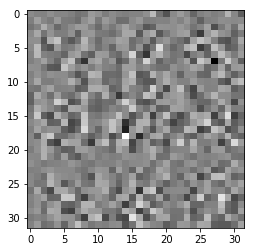

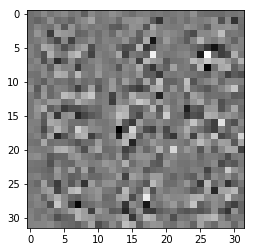

In [95]:
img_test_R = X_train[108].reshape(32,32,3)[:,:,0] # R channel of image of id 108
mask_x = np.array([[0,0,0],[-1,0,1],[0,0,0]]).reshape(3,3)
grad_x = convolve2d(img_test_R,mask_x,mode='same')
mask_y = np.array([[0,-1,0],[0,0,0],[0,1,0]]).reshape(3,3)
grad_y = convolve2d(img_test_R,mask_y,mode='same')
show_channel(grad_x,-1)
show_channel(grad_y,-1)
print(img_test_R.shape)
print(grad_x.shape)